In [34]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [36]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [37]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [38]:
tf.keras.backend.clear_session()

In [39]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [40]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


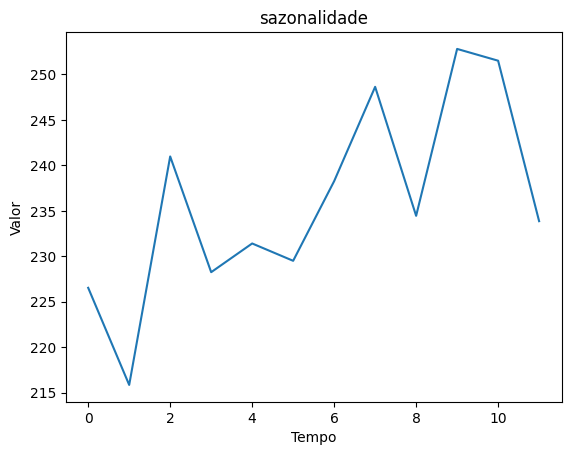

,sazonalidade
sazonalidade,
0,226.535776
1,215.861829
2,240.974809
3,228.253307
4,231.409887
5,229.504290
6,238.259767
7,248.628280
8,234.449571


In [41]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [42]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641,226.535776,188.093
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686,215.861829,170.973
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731,240.974809,174.880
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775,228.253307,178.111
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820,231.409887,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.409887,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.504290,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.259767,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.628280,NaN


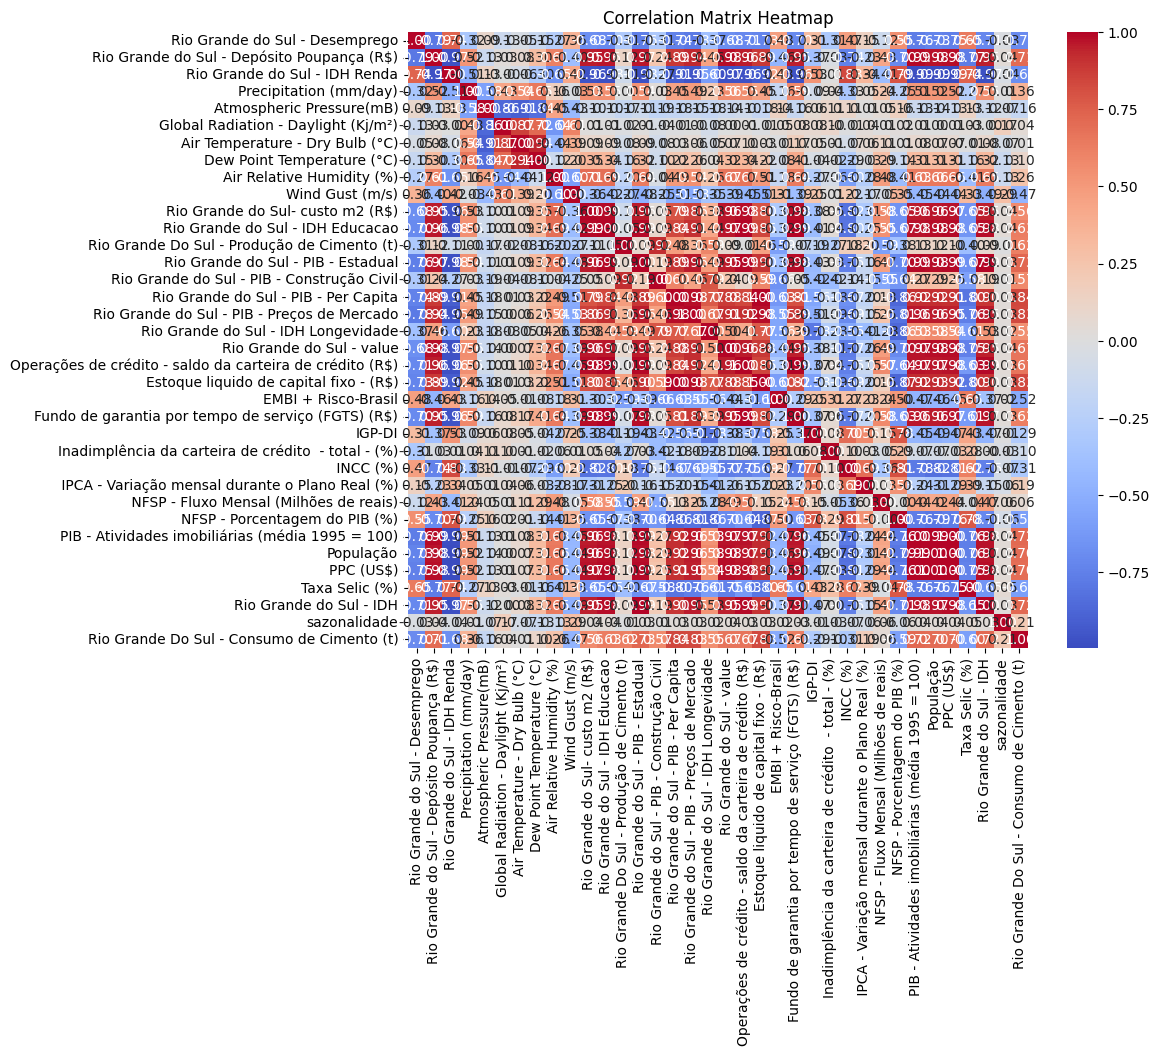

In [43]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [44]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)'], axis=1)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,72.391106,1.662459,11314.228000,0.701216,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641,226.535776,188.093
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,72.991721,1.632484,11415.287231,0.701343,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686,215.861829,170.973
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,74.540195,1.615540,11510.305379,0.701470,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731,240.974809,174.880
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,75.365237,1.576371,11603.969307,0.701596,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775,228.253307,178.111
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,75.732130,1.558359,11692.135859,0.701723,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820,231.409887,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.409887,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.504290,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.259767,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.628280,NaN


In [45]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade
0,1.274013,-1.544688,2.043474,1.576227,-1.131809,-1.139822,0.756248,-1.519422,-1.548955,-0.577787,-1.677139,-1.973850,-2.280022,-2.069914,-3.045436,-1.362004,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.691101,-0.896883
1,1.259068,-1.536101,2.014443,0.538673,-0.685826,-0.941173,0.574801,-1.497369,-1.537340,-0.629575,-1.660252,-1.934055,-2.253080,-2.045065,-2.959826,-1.371141,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.675868,-1.908108
2,1.244123,-1.527515,1.985413,-0.119963,-0.108112,-0.429024,0.472232,-1.476633,-1.525726,-0.640416,-1.643365,-1.894260,-2.226138,-2.020217,-2.874216,-1.382062,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.660635,0.471037
3,1.229178,-1.518929,1.956382,-0.596598,0.606614,-0.156146,0.235125,-1.456194,-1.514111,-0.692102,-1.626477,-1.854466,-2.199196,-1.995368,-2.788605,-1.392283,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.645402,-0.734168
4,1.214233,-1.510343,1.927351,-0.600701,1.290869,-0.034798,0.126091,-1.436954,-1.502496,-0.746144,-1.609590,-1.814671,-2.172254,-1.970520,-2.702995,-1.404146,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.630170,-0.435121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.966721,1.599667,-1.256680,-0.579375,0.685325,1.754749,1.086637,1.840013,1.439468,-1.420132,1.083219,-0.768157,0.374323,0.568222,-0.963093,1.591021,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.807464,1.196109
188,-0.973649,1.613722,-1.256039,-0.398075,-0.052113,1.243169,1.375057,1.863216,1.438014,-1.417824,1.070530,-0.760321,0.347418,0.545097,-1.053332,1.635348,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.773102,-0.147148
189,-0.980576,1.627777,-1.255398,-0.092262,-0.510276,0.768508,1.484294,1.887950,1.436561,-1.381727,1.057841,-0.752485,0.320513,0.521971,-1.143572,1.689944,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.738739,1.590857
190,-0.987503,1.641832,-1.254757,0.182289,-0.945695,0.485320,1.401656,1.915833,1.435107,-1.359803,1.045153,-0.744649,0.293608,0.498846,-1.233811,1.737741,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.704377,1.468145


In [46]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      174.261
1      164.909
2      202.662
3      174.149
4      159.955
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 273, dtype: float64

In [47]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade
0,1.274013,-1.544688,2.043474,1.576227,-1.131809,-1.139822,0.756248,-1.519422,-1.548955,-0.577787,-1.677139,-1.973850,-2.280022,-2.069914,-3.045436,-1.362004,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,4.398348,-1.873379,-2.042341,-1.825286,2.132459,-1.691101,-0.896883
1,1.259068,-1.536101,2.014443,0.538673,-0.685826,-0.941173,0.574801,-1.497369,-1.537340,-0.629575,-1.660252,-1.934055,-2.253080,-2.045065,-2.959826,-1.371141,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.675868,-1.908108
2,1.244123,-1.527515,1.985413,-0.119963,-0.108112,-0.429024,0.472232,-1.476633,-1.525726,-0.640416,-1.643365,-1.894260,-2.226138,-2.020217,-2.874216,-1.382062,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.660635,0.471037
3,1.229178,-1.518929,1.956382,-0.596598,0.606614,-0.156146,0.235125,-1.456194,-1.514111,-0.692102,-1.626477,-1.854466,-2.199196,-1.995368,-2.788605,-1.392283,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.645402,-0.734168
4,1.214233,-1.510343,1.927351,-0.600701,1.290869,-0.034798,0.126091,-1.436954,-1.502496,-0.746144,-1.609590,-1.814671,-2.172254,-1.970520,-2.702995,-1.404146,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.630170,-0.435121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.092018,0.615251,-1.302145,2.068330,-0.633376,1.248940,-0.244843,1.156608,1.317434,-0.647118,1.197586,-0.541459,0.739492,0.925913,1.242536,0.936850,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,-0.607704,0.952667,1.031384,1.044043,0.043807,1.430588,-1.908108
158,-0.148891,0.650960,-1.301817,1.084588,0.364458,1.751305,-0.547209,1.178293,1.324652,-0.689363,1.198866,-0.569240,0.731546,0.918346,1.181353,0.935032,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,-0.620523,0.954843,1.042716,1.056960,0.210856,1.419848,0.471037
159,-0.205765,0.686668,-1.301488,0.834408,0.907809,1.990735,-0.918047,1.200155,1.331871,-0.746341,1.200147,-0.597022,0.723600,0.910778,1.120171,0.935266,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,-0.631530,0.957019,1.054049,1.070172,0.107070,1.409108,-0.734168
160,-0.262638,0.722377,-1.301160,-0.114488,1.513590,2.052326,-1.361634,1.221919,1.339089,-0.811207,1.201428,-0.624803,0.715654,0.903211,1.058989,0.937596,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,-0.640320,0.956331,1.065381,1.083626,0.392942,1.398368,-0.435121


In [48]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      174.261
1      164.909
2      202.662
3      174.149
4      159.955
        ...   
157    196.675
158    251.395
159    199.081
160    220.793
161    211.546
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 162, dtype: float64

In [49]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [50]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 31)

In [51]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade
126,-1.124877,1.009786,-0.688461,-0.224942,1.330736,0.649854,-1.079202,0.391132,0.605326,0.966618,0.843865,0.507575,0.979193,1.048843,0.306206,0.602074,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.845653,0.213821
127,-1.048798,1.016380,-0.678623,0.145695,0.781105,0.277185,-0.408827,0.412919,0.625935,0.910075,0.861669,0.468267,0.975275,1.050210,0.273220,0.631855,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.440372,0.923198,0.664707,0.706933,-0.649312,0.868562,1.196109
128,-0.972719,1.022974,-0.668784,1.021044,-0.057609,-0.258140,0.008359,0.435303,0.646544,0.848166,0.879474,0.428960,0.971356,1.051577,0.240234,0.662142,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.891471,-0.147148
129,-0.896640,1.029568,-0.658946,1.108291,-0.687376,-0.759032,0.198873,0.457441,0.667153,0.792181,0.897278,0.389653,0.967437,1.052943,0.207248,0.695357,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.397019,0.941953,0.691327,0.723490,-1.288807,0.914380,1.590857
130,-0.820561,1.036162,-0.649108,0.887663,-1.257693,-1.113537,0.349047,0.480036,0.687763,0.728102,0.915082,0.350345,0.963518,1.054310,0.174262,0.719249,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.937288,1.468145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.966721,1.599667,-1.256680,-0.579375,0.685325,1.754749,1.086637,1.840013,1.439468,-1.420132,1.083219,-0.768157,0.374323,0.568222,-0.963093,1.591021,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,1.365911,1.413217,-1.311366,0.807464,1.196109
188,-0.973649,1.613722,-1.256039,-0.398075,-0.052113,1.243169,1.375057,1.863216,1.438014,-1.417824,1.070530,-0.760321,0.347418,0.545097,-1.053332,1.635348,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.773102,-0.147148
189,-0.980576,1.627777,-1.255398,-0.092262,-0.510276,0.768508,1.484294,1.887950,1.436561,-1.381727,1.057841,-0.752485,0.320513,0.521971,-1.143572,1.689944,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,1.387308,1.436067,-1.597784,0.738739,1.590857
190,-0.987503,1.641832,-1.254757,0.182289,-0.945695,0.485320,1.401656,1.915833,1.435107,-1.359803,1.045153,-0.744649,0.293608,0.498846,-1.233811,1.737741,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.704377,1.468145


In [52]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 31)

In [53]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [54]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [55]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(20)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [56]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1055799266, 3585089161, 1802129411, 2253514867, 2241603685, 207794554, 3884067015, 1910165966, 2848762536, 1911971651, 2003083978, 2428505377, 3969094424, 2739007019, 1809562097, 3245450274, 2780322345, 3322108175, 952762173, 2501569737]


Step: 0 ___________________________________________
val_loss: 122.86683654785156
winner_seed: 1055799266


Step: 1 ___________________________________________
val_loss: 141.25450134277344


Step: 2 ___________________________________________
val_loss: 152.81161499023438


Step: 3 ___________________________________________
val_loss: 164.9591522216797


Step: 4 ___________________________________________
val_loss: 157.32630920410156


Step: 5 ___________________________________________
val_loss: 128.6844482421875


Step: 6 ___________________________________________
val_loss: 145.82713317871094


Step: 7 ___________________________________________
val_loss: 128.4928436279297


Step: 8 ___________________________________________
val_loss: 154.86448669

In [57]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1668180562

Epoch 1/10000
4/4 [==============================] - 2s 135ms/step - loss: 46370.9961 - val_loss: 1886.9648
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 2376.9983 - val_loss: 1165.0286
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 1654.8429 - val_loss: 1126.2207
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 1566.2263 - val_loss: 1068.6858
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 1642.9039 - val_loss: 1061.8113
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 1564.8818 - val_loss: 1081.7285
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 1523.6182 - val_loss: 1450.2628
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 1683.0515 - val_loss: 1078.2299
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 1755.0503 - val_loss: 1012.8699
Epoch 10/10000
4/4 [========================

Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 761.9995 - val_loss: 261.4460
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 395.7770 - val_loss: 368.6397
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 436.6732 - val_loss: 402.2333
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 439.9844 - val_loss: 347.4450
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 344.8349 - val_loss: 339.5284
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 338.8286 - val_loss: 234.7919
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 341.8045 - val_loss: 276.4120
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 354.7545 - val_loss: 217.9740
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 336.5534 - val_loss: 279.4133
Epoch 88/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 11ms/step - loss: 207.6139 - val_loss: 242.5225
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 235.9469 - val_loss: 237.1745
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.3576 - val_loss: 146.6849
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 182.1818 - val_loss: 124.8550
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 186.5012 - val_loss: 120.2806
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 195.2512 - val_loss: 168.4019
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 235.3383 - val_loss: 144.0098
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 192.3593 - val_loss: 116.8549
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 212.4011 - val_loss: 150.2440
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step

4/4 [==============================] - 0s 12ms/step - loss: 179.6054 - val_loss: 238.0697
Epoch 388/10000
4/4 [==============================] - 0s 14ms/step - loss: 175.5524 - val_loss: 75.3852
Epoch 389/10000
4/4 [==============================] - 0s 12ms/step - loss: 126.8579 - val_loss: 83.0855
Epoch 390/10000
4/4 [==============================] - 0s 12ms/step - loss: 123.5070 - val_loss: 104.9197
Epoch 391/10000
4/4 [==============================] - 0s 13ms/step - loss: 135.4167 - val_loss: 150.8520
Epoch 392/10000
4/4 [==============================] - 0s 15ms/step - loss: 167.4909 - val_loss: 142.0678
Epoch 393/10000
4/4 [==============================] - 0s 13ms/step - loss: 144.1367 - val_loss: 140.7862
Epoch 394/10000
4/4 [==============================] - 0s 15ms/step - loss: 134.1637 - val_loss: 121.2598
Epoch 395/10000
4/4 [==============================] - 0s 13ms/step - loss: 137.8503 - val_loss: 114.7739
Epoch 396/10000
4/4 [==============================] - 0s 12ms/s

Epoch 542/10000
4/4 [==============================] - 0s 15ms/step - loss: 94.0340 - val_loss: 155.1779
Epoch 543/10000
4/4 [==============================] - 0s 14ms/step - loss: 99.6734 - val_loss: 221.9744
Epoch 544/10000
4/4 [==============================] - 0s 12ms/step - loss: 115.2146 - val_loss: 95.6077
Epoch 545/10000
4/4 [==============================] - 0s 13ms/step - loss: 150.0164 - val_loss: 121.3148
Epoch 546/10000
4/4 [==============================] - 0s 14ms/step - loss: 121.5437 - val_loss: 163.3859
Epoch 547/10000
4/4 [==============================] - 0s 13ms/step - loss: 98.5476 - val_loss: 112.5979
Epoch 548/10000
4/4 [==============================] - 0s 15ms/step - loss: 142.9851 - val_loss: 90.3193
Epoch 549/10000
4/4 [==============================] - 0s 13ms/step - loss: 92.0808 - val_loss: 239.1354
Epoch 550/10000
4/4 [==============================] - 0s 13ms/step - loss: 104.2521 - val_loss: 202.4086
Epoch 551/10000
4/4 [==============================]

Epoch 620/10000
4/4 [==============================] - 0s 14ms/step - loss: 95.7791 - val_loss: 66.7620
Epoch 621/10000
4/4 [==============================] - 0s 12ms/step - loss: 83.4802 - val_loss: 97.7803
Epoch 622/10000
4/4 [==============================] - 0s 12ms/step - loss: 107.8737 - val_loss: 84.8623
Epoch 623/10000
4/4 [==============================] - 0s 11ms/step - loss: 116.5841 - val_loss: 234.1950
Epoch 624/10000
4/4 [==============================] - 0s 11ms/step - loss: 147.9086 - val_loss: 91.9011
Epoch 625/10000
4/4 [==============================] - 0s 12ms/step - loss: 87.7134 - val_loss: 72.3539
Epoch 626/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.9133 - val_loss: 67.7735
Epoch 627/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.2004 - val_loss: 74.0472
Epoch 628/10000
4/4 [==============================] - 0s 12ms/step - loss: 87.4535 - val_loss: 78.8731
Epoch 629/10000
4/4 [==============================] - 0s 12

4/4 [==============================] - 0s 13ms/step - loss: 75.2595 - val_loss: 122.7442
Epoch 777/10000
4/4 [==============================] - 0s 12ms/step - loss: 67.7021 - val_loss: 161.5027
Epoch 778/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.6191 - val_loss: 170.2140
Epoch 779/10000
4/4 [==============================] - 0s 13ms/step - loss: 76.2743 - val_loss: 234.9711
Epoch 780/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.0392 - val_loss: 147.4175
Epoch 781/10000
4/4 [==============================] - 0s 13ms/step - loss: 53.6063 - val_loss: 167.3869
Epoch 782/10000
4/4 [==============================] - 0s 14ms/step - loss: 61.3351 - val_loss: 147.1551
Epoch 783/10000
4/4 [==============================] - 0s 12ms/step - loss: 99.2524 - val_loss: 120.7749
Epoch 784/10000
4/4 [==============================] - 0s 13ms/step - loss: 61.6082 - val_loss: 132.7739
Epoch 785/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 50.2506 - val_loss: 128.9185
Epoch 933/10000
4/4 [==============================] - 0s 12ms/step - loss: 49.7555 - val_loss: 145.1506
Epoch 934/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.8469 - val_loss: 170.2798
Epoch 935/10000
4/4 [==============================] - 0s 12ms/step - loss: 43.5455 - val_loss: 157.9184
Epoch 936/10000
4/4 [==============================] - 0s 12ms/step - loss: 58.0611 - val_loss: 166.8591
Epoch 937/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.4722 - val_loss: 162.9247
Epoch 938/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.1431 - val_loss: 185.0463
Epoch 939/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.4429 - val_loss: 103.6563
Epoch 940/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.8686 - val_loss: 161.0496
Epoch 941/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 36.8685 - val_loss: 149.1352
Epoch 1011/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.3079 - val_loss: 177.7647
Epoch 1012/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.4671 - val_loss: 156.4124
Epoch 1013/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.1622 - val_loss: 135.9082
Epoch 1014/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.3729 - val_loss: 134.5365
Epoch 1015/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.0154 - val_loss: 168.0233
Epoch 1016/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.1763 - val_loss: 158.7227
Epoch 1017/10000
4/4 [==============================] - 0s 14ms/step - loss: 49.6731 - val_loss: 143.1724
Epoch 1018/10000
4/4 [==============================] - 0s 14ms/step - loss: 51.4144 - val_loss: 129.9429
Epoch 1019/10000
4/4 [==============================] - 0s 13ms

In [58]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [59]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,245.002136,252.806183,216.764572,250.687439,248.135452,207.36972,205.961975,205.55722,233.920547,207.39682,215.3358,214.990738,222.580139,251.101105,225.72522,244.702972,242.458359,211.730225,209.111923,208.348877,213.2258,212.620438,214.583496,216.383057,222.3703,236.145401,234.19899,232.904617,222.957993,226.497589
Target,244.68,252.183,249.403,208.299,238.414,213.179,221.534,212.139,228.994,226.827,186.855,253.021,194.988,244.406,201.372,251.369,242.782,201.288,226.547,228.5,223.896,234.132,207.586,228.583,234.565,249.519,230.086,233.136,233.8,223.214
Error,0.322144,0.623184,32.638428,42.388443,9.721451,5.80928,15.572021,6.581787,4.926544,19.430176,28.480804,38.030258,27.592133,6.695099,24.353226,6.666031,0.323639,10.44223,17.435074,20.151123,10.670197,21.511566,6.997498,12.199936,12.194702,13.373596,4.112991,0.231384,10.84201,3.283585


In [60]:
display(mae)
display(mape)

13.786684

0.06214218

In [61]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [62]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[2703.9285]] - Target[2735.5280000000002]| =  Error: [[31.59961]]; MAPE:[[0.01155156]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[2672.5718]] - Target[2685.449]| =  Error: [[12.877197]]; MAPE:[[0.00479517]]
1/1 [==============================] - 0s 18ms/step
Ano-5: |Prediction[[1375.0748]] - Target[1404.32]| =  Error: [[29.245117]]; MAPE:[[0.02082511]]


[array([[31.59961]], dtype=float32),
 array([[12.877197]], dtype=float32),
 array([[29.245117]], dtype=float32)]

24.573975

0.012390614